# **<center>SDSC3006 Lab : Classification with kNN and Cross-Validation</center>**

TA : Nathanael Tepakbong (Nath)  
Email : ntepakbo-c@my.cityu.edu.hk  
Source material : https://www.statlearning.com/

## I - Classification with the K-Nearest Neighbors Algorithm :

We will start by performing classification on the Stock Market Dataset using the kNN algorithm. Since we used the same dataset last week when using other classification algorithms, we thus have a reference to which we can compare our results.

### Importing the necessary packages :

As in the previous labs, we install the `ISLP` library together with the usual packages.

In [1]:
!pip install ISLP==0.3.19

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)

We also import the kNN classifier from ``sklearn``, as well as two other useful metrics from `ISLP`.

In [3]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### The Stock Market dataset :

We will now load the ``Smarket`` dataset. We've already seen it, but as a reminder, this data set consists of percentage returns for the S&P 500
stock index over 1,250 days, from the beginning of 2001 until the end
of 2005.

For each date, the percentage returns for
each of the five previous trading days have been recorded,  `Lag1`  through
 `Lag5`. The other recorded values are `Volume` (number of
shares traded on the previous day, in billions),  `Today` (the
percentage return on the date in question) and  `Direction`
(whether the market was  `Up`  or  `Down`  on this date).


In [4]:
Smarket = load_data('Smarket')
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [5]:
Smarket.columns #see what the variables' names are

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

We compute the correlation matrix using the `corr()` method
for data frames, which produces a matrix that contains all of
the pairwise correlations among the variables.

By instructing `pandas` to use only numeric variables, the `corr()` method does not report a correlation for the `Direction`  variable because it is
 qualitative.

In [6]:
Smarket.corr(numeric_only=True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


As one would expect, the correlations between the lagged return  variables and
today’s return are close to zero.  The only substantial correlation is between  `Year`  and
 `Volume`. By plotting the data we see that  `Volume`
is increasing over time. In other words, the average number of shares traded
daily increased from 2001 to 2005.


<Axes: >

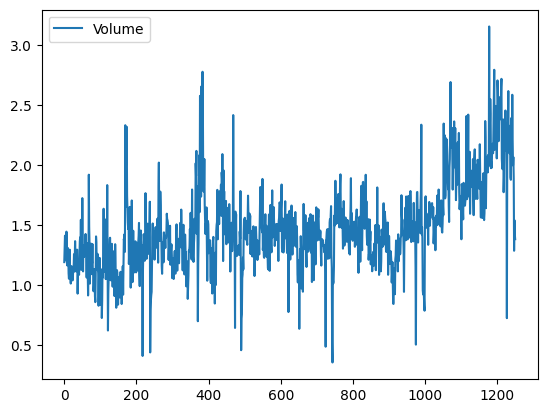

In [7]:
Smarket.plot(y='Volume')

### k-Nearest Neighbors :

We will now perform KNN classification using the ``KNeighborsClassifier()`` function. This function works similarly to the other model-fitting functions that we have encountered thus far.  

As is the case for LDA and QDA, we fit the classifier using the ``fit``
method. New predictions are formed using the ``predict`` method of the object
returned by ``fit()``.

In [8]:
#reloading the variables from previous lab

allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'

train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]

X_train , X_test = X.loc[train], X.loc[~train]
y_train , y_test = y.loc[train], y.loc[~train]

D = Smarket.Direction
L_train , L_test = D.loc[train], D.loc[~train]

In [9]:
knn2 = KNeighborsClassifier(n_neighbors=2)
knn2.fit(X_train , L_train)
knn2_pred = knn2.predict(X_test)
confusion_table(knn2_pred , L_test)

Truth,Down,Up
Predicted,,
Down,75,101
Up,36,40


The results are rather bad, as would be expected since we are trying to fit with only ``k=2`` neighbors :

In [10]:
np.mean(knn2_pred == L_test)

0.45634920634920634

Let's increase the number of neighbors to ``n_neighbors=3`` :

In [11]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3_pred = knn3.fit(X_train , L_train).predict(X_test)
np.mean(knn3_pred == L_test)

0.503968253968254

The accuracy has improved, but not substantially. We could try to increase ``n_neighbors`` further to improve the quality of the model, at th expense of more computations. (**Exercise :** fit a kNN model to the ``Smarket`` for different values of ``n_neighbors`` and plot the evolution of the accuracy with respect to the number of neighbors. Are those the results you expected ? Why ?)  

As it turns out, kNN simply performs quite badly on ``Smarket`` dataset, especially compared to other methods we've seen last week.  

However, kNN can be a very powerful algorithm in many cases, so let's look at another example.

### The Caravan Dataset :

We will apply now the kNN approach to the ``Caravan`` data set, which is part of the ``ISLP`` library. This data set includes 85 predictors that measure demographic characteristics for 5,822 individuals.  

The response variable is ``Purchase``, which indicates whether or not a given
individual purchases a caravan insurance policy. In this data set, only 6%
of people purchased caravan insurance.

In [12]:
Caravan = load_data('Caravan')
Purchase = Caravan.Purchase
Purchase.value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [13]:
Purchase.value_counts?

In [14]:
348 / 5822

0.05977327378907592

We will use all of the features for the prediction of ``Purchase``.

In [15]:
feature_df = Caravan.drop(columns=['Purchase'])
feature_df

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,1,2,8,0,6,1,2,1,...,2,0,0,0,1,0,0,0,0,0
5818,35,1,4,4,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
5819,33,1,3,4,8,0,6,0,3,5,...,0,0,0,0,1,0,0,0,0,0
5820,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,0


As we can see if we look up the dataset details, the columns are highly non-homogeneous : some values are ages in years, others are salaries in the thousands of USD etc... This is not good, because kNN is based on the Euclidean distance between feature points, hence the model would roughly see a difference of yearly salary of 1000 USD as 100 times more significant than an age gap of 10 years (!), and will most likely lead to wrong predictions.  

To fix this, we will perform a so-called *standardization* the data so that all variables are given a mean of zero and a standard deviation of one. Then all variables will be on a comparable scale. This is accomplished using the
``StandardScaler()`` transformation.

In [16]:
scaler = StandardScaler(with_mean=True,
with_std=True,
copy=True)

The argument ``with_mean`` indicates whether or not we should subtract the
mean, while ``with_std`` indicates whether or not we should scale the columns
to have standard deviation of 1 or not. Finally, the argument ``copy=True`` indicates that we will always copy data, rather than trying to do calculations
in place where possible.  


This transformation can be fit and then applied to arbitrary data. In the
first line below, the parameters for the scaling are computed and stored
in ``scaler``, while the second line actually constructs the standardized set of
features.

In [17]:
scaler.fit(feature_df)
X_std = scaler.transform(feature_df)

We can now check that every column of ``feature_std`` below has a standard deviation of one and a mean of zero. (The fact that the variances are not exactly 1 is due to a mismatch of conventions, between dividing the empirical variance by $n$  or $n-1$. It doesn't matter as long as all the features are on the same scale)

In [18]:
feature_std = pd.DataFrame(X_std, columns=feature_df.columns)
feature_std.std()

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64

We now split the data into testing and training set using ``train_test_split``

In [19]:
(X_train, X_test ,
y_train, y_test) = train_test_split(feature_std,
Purchase,
test_size=1000,
random_state=0) #for reproducibility

In [20]:
?train_test_split

We fit a kNN model on the training data using ``n_neighbors=1``, and evaluate its performance on the test data :

In [21]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train , y_train).predict(X_test)
np.mean(y_test != knn1_pred), np.mean(y_test != "No")

(0.111, 0.067)

The error rate of $\approx 11\%$ seems good, but note that if we only predicted ``No`` for all inputs, we could get down to $6\%$ ! The rate obtained when only predicting a negative output is called the *null rate*.  

For an insurance seller, picking clients at random yields a 6% probability of making a sale, which is very low. We want to see if picking clients according to the kNN prediction improves this rate. It can be done as follows :

In [22]:
confusion_table(knn1_pred , y_test)

Truth,No,Yes
Predicted,,
No,880,58
Yes,53,9


In [23]:
9/(53+9)

0.14516129032258066

We go from 6% to 14.5% probability of successful sale. As we hoped, the kNN did improve our prediction performance compared to random guessing !

### Tuning parameters :

The number of neighbors in kNN is referred to as a *tuning parameter*, also
referred to as a *hyperparameter*. We do not know a priori what value to use. It is therefore of interest to see how the classifier performs on test
data as we vary these parameters.  

This can be achieved with a ``for`` loop : we use a ``for`` loop to look at the accuracy of our classifier in the group predicted to purchase insurance as we vary the number of neighbors from 1 to 5:

In [24]:
for K in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train , y_train).predict(X_test)

    C = confusion_table(knn_pred, y_test)

    templ = ('K={0:d}: # predicted to rent: {1:>2},' +
        ' # who did rent {2:d}, accuracy {3:.1%}')

    pred = C.loc['Yes'].sum()
    did_rent = C.loc['Yes','Yes']

    print(templ.format(K,pred ,did_rent , did_rent / pred))

K=1: # predicted to rent: 62, # who did rent 9, accuracy 14.5%
K=2: # predicted to rent:  6, # who did rent 1, accuracy 16.7%
K=3: # predicted to rent: 20, # who did rent 3, accuracy 15.0%
K=4: # predicted to rent:  4, # who did rent 0, accuracy 0.0%
K=5: # predicted to rent:  7, # who did rent 1, accuracy 14.3%


### Comparison with logistic regression :

In [25]:
logit = LogisticRegression(C=1e10 , solver='liblinear')
logit.fit(X_train , y_train)
logit_pred = logit.predict_proba(X_test)
logit_labels = np.where(logit_pred[:,1] > 0.5, 'Yes', 'No')
confusion_table(logit_labels , y_test)

Truth,No,Yes
Predicted,,
No,931,67
Yes,2,0


Problem ! Almost ll features are predicted to be ``No`` ! We  can fix it by changing the cut-off from 50% to 25% :

In [26]:
logit_labels = np.where(logit_pred[:,1]>0.25, 'Yes', 'No')
confusion_table(logit_labels , y_test)

Truth,No,Yes
Predicted,,
No,913,58
Yes,20,9


In [27]:
9/(20+9)

0.3103448275862069

We get over 30% of accurate predictions, which is more than twice the amount obtained for kNN !

## II - Cross-Validation :

We start by importing additional packages which will be of use for the following part of this lab.

In [28]:
from functools import partial
from sklearn.model_selection import \
(cross_validate ,
KFold ,
ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm
from ISLP.models import (ModelSpec as MS, summarize, poly)

### The validation set approach :

We will explore the use of the validation set approach in order to estimate the
test error rates that result from fitting various linear models on the ``Auto``
data set.

In [29]:
Auto = load_data('Auto')
Auto_train , Auto_valid = train_test_split(Auto,
test_size=196,
random_state=0) #for reproducibility

In [30]:
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [31]:
#fitting an ordinary linear model
hp_mm = MS(['horsepower'])

X_train = hp_mm.fit_transform(Auto_train)
y_train = Auto_train['mpg']
model = sm.OLS(y_train , X_train)
results = model.fit()

In [32]:
#computing the MSE
X_valid = hp_mm.transform(Auto_valid)
y_valid = Auto_valid['mpg']
valid_pred = results.predict(X_valid)
np.mean((y_valid - valid_pred)**2)

23.61661706966988

We can likewise compute the validation MSE for higher order models. For that we will create a helper function ``evalMSE()`` which takes a model, a training and a testing set as input and outputs the MSE of a model trained on such data :

In [33]:
def evalMSE(terms ,
    response,
    train,
    test):

    mm = MS(terms)
    X_train = mm.fit_transform(train)
    y_train = train[response]
    X_test = mm.transform(test)
    y_test = test[response]

    results = sm.OLS(y_train , X_train).fit()
    test_pred = results.predict(X_test)

    return np.mean((y_test - test_pred)**2)

We can now use our function to test the performance of linear, quadratic and cubic models to the ``Auto`` dataset.

In [34]:
MSE = np.zeros(3)

for idx , degree in enumerate(range(1, 4)):
    MSE[idx] = evalMSE([poly('horsepower', degree)],
        'mpg',
        Auto_train,
        Auto_valid)

MSE

array([23.61661707, 18.76303135, 18.79694163])

We can reiterate the procedure on a different training/validation split to check whether the results are consistent :

In [35]:
Auto_train , Auto_valid = train_test_split(Auto, test_size=196, random_state=3)

MSE = np.zeros(3)

for idx , degree in enumerate(range(1, 4)):
    MSE[idx] = evalMSE([poly('horsepower', degree)],
        'mpg',
        Auto_train,
        Auto_valid)

MSE

array([20.75540796, 16.94510676, 16.97437833])

### Cross-Validation :

``sklearn`` provides a simple API to perform cross-validation. Unforutnately it is not compatible with ``statsmodels``, which is the one we've been using to fit our data. To fix this, the ``ISLP`` package provides a *wrapper function* ``sklearn_sm`` which will allow us to perform ``sklearn`` cross validation with models fitted using ``statsmodels``. Here is how it can be used :

In [36]:
hp_model = sklearn_sm(sm.OLS, MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']

cv_results = cross_validate(hp_model, X, Y, cv=Auto.shape[0])
cv_err = np.mean(cv_results['test_score'])
cv_err

24.23151351792922

The arguments to ``cross_validate()`` are as follows : an object with the appropriate ``fit()``, ``predict()``, and ``score()`` methods, an array of features ``X`` and a response ``Y``. We also included an additional argument ``cv`` to ``cross_validate()``; specifying an integer K results in K-fold cross-validation.  
We have provided a value corresponding to the total number of observations, which results in leave-one-out cross-validation (LOOCV). The ``cross_validate()`` function produces a dictionary with several components; we simply want the
cross-validated test score here (MSE), which is estimated to be 24.23.

We can repeat this procedure for increasingly complex polynomial fits.
To automate the process, we again use a ``for`` loop which iteratively fits
polynomial regressions of degree 1 to 5, computes the associated crossvalidation
error, and stores it in the ith element of the vector ``cv_error``.

In [37]:
cv_error = np.zeros(5)
H = np.array(Auto['horsepower'])
M = sklearn_sm(sm.OLS)

for i, degree in enumerate(range(1,6)):
    X = np.power.outer(H, np.arange(degree+1))
    M_CV = cross_validate(M, X, Y, cv=Auto.shape[0])
    cv_error[i] = np.mean(M_CV['test_score'])

cv_error

array([24.23151352, 19.24821312, 19.33498406, 19.42443029, 19.03320648])

We just performed $K=n-$fold cross-validation, but we can of course do $K<n$ cross-validation as well, by slightly adapting the above code and using the function ``KFold()`` to partition the data in $K=10$ random groups :

In [38]:
cv_error = np.zeros(5)
cv = KFold(n_splits=10, shuffle=True,
random_state=0) # use same splits for each degree

for i, degree in enumerate(range(1,6)):
    X = np.power.outer(H, np.arange(degree+1))
    M_CV = cross_validate(M, X, Y, cv=cv)
    cv_error[i] = np.mean(M_CV['test_score'])

cv_error

array([24.20766449, 19.18533142, 19.27626666, 19.47848403, 19.13720065])

``cross_validate`` is quite flexible and allows for different splitting mechanisms as arguments, such as ``ShuffleSplit()`` for instance

In [39]:
validation = ShuffleSplit(n_splits=1, test_size=196, random_state=0)
results = cross_validate(hp_model , Auto.drop(['mpg'], axis=1),
    Auto['mpg'],
    cv=validation)
results['test_score']

array([23.61661707])

And we can also estimate the variability in the test results by running the following :

In [40]:
validation = ShuffleSplit(n_splits=10, test_size=196, random_state=0)
results = cross_validate(hp_model, Auto.drop(['mpg'], axis=1),
                         Auto['mpg'],
                         cv=validation)
results['test_score'].mean(), results['test_score'].std()

(23.802232661034168, 1.4218450941091842)